In [1]:
# import copy
import json
import pickle
# from pathlib import Path
# import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

import matplotlib.pyplot as plt

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping #, LearningRateMonitor

# from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
# from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.metrics import QuantileLoss #MAE, SMAPE, PoissonLoss, 
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\pytorch_forecasting\models\base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
with open("../utils/columns.json", 'rb') as file:
    column_names = json.load(file)['trainTestColumns']

In [3]:
column=["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5","sensor6","sensor7","sensor8",
         "sensor9","sensor10","sensor11","sensor12","sensor13","sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
         ,"sensor20","sensor21","sensor22","sensor23"]

In [4]:
train=pd.read_csv("../data/train_FD001.txt",sep=" ",names=column)

In [5]:
def prepare_train_data(data, factor = 0):
    df = data.copy()
    fd_RUL = df.groupby('engine')['cycle'].max().reset_index()
    fd_RUL = pd.DataFrame(fd_RUL)
    fd_RUL.columns = ['engine','max']
    df = df.merge(fd_RUL, on=['engine'], how='left')
    df['RUL'] = df['max'] - df['cycle']
    df.drop(columns=['max'],inplace = True)
    return df[df['cycle'] > factor]

In [6]:
test=pd.read_csv("../data/test_FD001.txt",sep=" ",names=column)
test_results=pd.read_csv("../data/RUL_FD001.txt",sep=" ",header=None)

test_results.columns=["rul","null"]
test_results.drop(["null"],axis=1,inplace=True)
test_results['id']=test_results.index+1
rul = pd.DataFrame(test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']

test_results['rul_failed']=test_results['rul']+rul['max']
test_results.drop(["rul"],axis=1,inplace=True)

test=test.merge(test_results,on=['id'],how='left')
test["RUL"]=test["rul_failed"]-test["cycle"]
test.drop(columns=['rul_failed'], inplace=True)

In [7]:
te_null_df = pd.DataFrame(test.isnull().sum()).T
te_null_df[te_null_df > 0].dropna(axis=1) # Showing only column with values other than 0

,sensor22,sensor23
0,13096,13096


In [8]:
tr_null_df = pd.DataFrame(train.isnull().sum()).T
tr_null_df[tr_null_df > 0].dropna(axis=1) # Showing only column with values other than 0

,sensor22,sensor23
0,20631,20631


In [9]:
null_cols = ["sensor22","sensor23"]
#Dropping null columns
df_train=train.drop(null_cols,axis=1)
df_train.columns = column_names
df_train = prepare_train_data(df_train)

test_df=test.drop(null_cols,axis=1)
test_df.columns = column_names+['RUL']

In [10]:
sensor_measurements = df_train.drop(columns=['engine', 'cycle', 'RUL']).columns.to_list()

In [11]:
uniq_val_col = []
for col in sensor_measurements:
    if df_train[col].nunique() ==1:
        uniq_val_col.append(col)

In [12]:
sensor_measurements = [col for col in sensor_measurements if col not in uniq_val_col]

In [14]:
linear_corr = df_train[sensor_measurements].corr(method='pearson')
nonlinear_corr_spearman = df_train[sensor_measurements].corr(method='spearman')

In [15]:
def high_corr_col(linear_corr):
    threshold = 0.85

    # Identify columns to drop based on Pearson correlation
    high_corr = np.where(abs(linear_corr) > threshold)
    high_corr_pairs = [(linear_corr.index[x], linear_corr.columns[y]) for x, y in zip(*high_corr) if x != y]

    # Track columns to drop, avoiding duplicates
    to_drop = set()
    for (col1, col2) in high_corr_pairs:
        to_drop.add(col1 if col1 not in to_drop else col2)

    print("Columns dropped:", to_drop)
    return list(to_drop)

In [16]:
lin_col_to_drop = high_corr_col(linear_corr)
non_lin_col_to_drop = high_corr_col(nonlinear_corr_spearman)

Columns dropped: {'Physical_core_speed_rpm', 'Corrected_core_speed_rpm'}
Columns dropped: {'Physical_core_speed_rpm', 'Corrected_core_speed_rpm'}


In [17]:
df_train.drop(columns= lin_col_to_drop+uniq_val_col, inplace=True)
test_df.drop(columns= lin_col_to_drop+uniq_val_col, inplace=True)

In [18]:
sensor_measurements = [col for col in sensor_measurements if col not in lin_col_to_drop and col not in uniq_val_col]

In [19]:
scaler = StandardScaler()
df_train[sensor_measurements] = scaler.fit_transform(df_train[sensor_measurements])
test_df[sensor_measurements] = scaler.transform(test_df[sensor_measurements])

In [20]:
pd.set_option("display.max_columns", None)

In [21]:
# Define a column for time indexing and target
test_df["time_idx"] = test_df.groupby("engine").cumcount()

test_df["target"] = test_df["RUL"]
test_df.drop(columns=['RUL'], inplace= True)

test_df['engine'] = test_df['engine'].astype(str)

In [22]:
# Define a column for time indexing and target
df_train["time_idx"] = df_train.groupby("engine").cumcount()
df_train["target"] = df_train["RUL"]
df_train.drop(columns=['RUL'], inplace= True)
df_train['engine'] = df_train['engine'].astype(str)

In [23]:
# Split into train, validation, and test sets
train_df, val_df = np.split(df_train, [int(.8*len(df_train))])

c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [24]:
# Define the max encoder and prediction lengths (can be adjusted based on sequence length requirements)
max_encoder_length = 20  # input sequence length
max_prediction_length = 1  # forecasting one time step

# Define dataset for the Temporal Fusion Transformer
training = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    target="target",
    group_ids=["engine"], # columns that uniquely identify each time series group
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["engine"],
    time_varying_known_reals=['time_idx'] + sensor_measurements,
    time_varying_unknown_reals=["target"],
    # target_normalizer=GroupNormalizer(groups=["engine"]),
    categorical_encoders={"engine": NaNLabelEncoder(add_nan=True)},
    allow_missing_timesteps=True 
)

In [25]:
import pickle
with open("../model/tft_training2.pkl", "wb") as file:
    pickle.dump(training, file)

In [26]:
# Create DataLoaders
batch_size = 64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=4)

In [27]:
validation = TimeSeriesDataSet.from_dataset(training, val_df, predict=False, stop_randomization=True)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=4)

c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\pytorch_forecasting\data\encoders.py:314: UserWarning: Found 18 unknown classes which were set to NaN
  warnings.warn(


In [28]:
# # Create test dataset without `predict=True` to use all time points
testing = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)
test_dataloader = testing.to_dataloader(train=False, batch_size=batch_size, num_workers=4)

c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\pytorch_forecasting\data\encoders.py:314: UserWarning: Found 18 unknown classes which were set to NaN
  warnings.warn(


In [29]:
# Instantiate the Temporal Fusion Transformer model
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # quantiles (0.1 to 0.9 by 0.1)
    loss=QuantileLoss(),
    reduce_on_plateau_patience=4,
)

c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer.

In [30]:
max_epochs=100
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    patience=10,  # Higher patience for extended training
    mode="min",
    verbose=True
)

trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[early_stop_callback]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [32]:
#tst

In [31]:
# Train the model
trainer.fit(tft, train_dataloader, val_dataloader)


   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K  | train
3  | prescalers                         | ModuleDict                      | 272    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 48     | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 12.4 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 11.7 K | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 0: 100%|██████████| 232/232 [00:55<00:00,  4.14it/s, v_num=45, train_loss_step=2.560, val_loss=3.200, train_loss_epoch=19.70]

Metric val_loss improved. New best score: 3.204


Epoch 1: 100%|██████████| 232/232 [01:25<00:00,  2.70it/s, v_num=45, train_loss_step=3.040, val_loss=2.180, train_loss_epoch=3.140]

Metric val_loss improved by 1.019 >= min_delta = 0.0. New best score: 2.185


Epoch 4: 100%|██████████| 232/232 [01:25<00:00,  2.70it/s, v_num=45, train_loss_step=2.330, val_loss=2.080, train_loss_epoch=1.920]

Metric val_loss improved by 0.106 >= min_delta = 0.0. New best score: 2.079


Epoch 5: 100%|██████████| 232/232 [01:24<00:00,  2.75it/s, v_num=45, train_loss_step=2.010, val_loss=1.530, train_loss_epoch=1.790]

Metric val_loss improved by 0.554 >= min_delta = 0.0. New best score: 1.525


Epoch 6: 100%|██████████| 232/232 [01:25<00:00,  2.71it/s, v_num=45, train_loss_step=1.580, val_loss=1.030, train_loss_epoch=1.760]

Metric val_loss improved by 0.496 >= min_delta = 0.0. New best score: 1.029


Epoch 12: 100%|██████████| 232/232 [01:15<00:00,  3.07it/s, v_num=45, train_loss_step=0.843, val_loss=0.813, train_loss_epoch=1.010]

Metric val_loss improved by 0.216 >= min_delta = 0.0. New best score: 0.813


Epoch 15: 100%|██████████| 232/232 [01:20<00:00,  2.87it/s, v_num=45, train_loss_step=0.927, val_loss=0.734, train_loss_epoch=1.210]

Metric val_loss improved by 0.079 >= min_delta = 0.0. New best score: 0.734


Epoch 21: 100%|██████████| 232/232 [01:47<00:00,  2.15it/s, v_num=45, train_loss_step=0.990, val_loss=0.615, train_loss_epoch=0.797]

Metric val_loss improved by 0.119 >= min_delta = 0.0. New best score: 0.615


Epoch 23: 100%|██████████| 232/232 [02:31<00:00,  1.53it/s, v_num=45, train_loss_step=0.681, val_loss=0.571, train_loss_epoch=0.814]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 0.571


Epoch 24: 100%|██████████| 232/232 [02:33<00:00,  1.51it/s, v_num=45, train_loss_step=0.716, val_loss=0.564, train_loss_epoch=0.756]

Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.564


Epoch 29: 100%|██████████| 232/232 [02:49<00:00,  1.37it/s, v_num=45, train_loss_step=0.485, val_loss=0.496, train_loss_epoch=0.722]

Metric val_loss improved by 0.068 >= min_delta = 0.0. New best score: 0.496


Epoch 37: 100%|██████████| 232/232 [01:25<00:00,  2.70it/s, v_num=45, train_loss_step=0.691, val_loss=0.492, train_loss_epoch=0.583]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.492


Epoch 38: 100%|██████████| 232/232 [01:29<00:00,  2.58it/s, v_num=45, train_loss_step=0.540, val_loss=0.451, train_loss_epoch=0.611]

Metric val_loss improved by 0.041 >= min_delta = 0.0. New best score: 0.451


Epoch 40: 100%|██████████| 232/232 [01:31<00:00,  2.53it/s, v_num=45, train_loss_step=0.639, val_loss=0.446, train_loss_epoch=0.588]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.446


Epoch 49: 100%|██████████| 232/232 [01:13<00:00,  3.14it/s, v_num=45, train_loss_step=0.423, val_loss=0.419, train_loss_epoch=0.515]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 0.419


Epoch 59: 100%|██████████| 232/232 [01:16<00:00,  3.04it/s, v_num=45, train_loss_step=0.444, val_loss=0.617, train_loss_epoch=0.476]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.419. Signaling Trainer to stop.


Epoch 59: 100%|██████████| 232/232 [01:16<00:00,  3.03it/s, v_num=45, train_loss_step=0.444, val_loss=0.617, train_loss_epoch=0.476]


In [33]:
def evaluate(y_true, y_pred):
    print(f'RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f}')
    print(f'MAE: {mean_absolute_error(y_true, y_pred):.2f}')
    print(f'r2 score: {r2_score(y_true, y_pred):.2f}')
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Create a mask for non-zero actual values
    act_non_zero_mask = y_true != 0

    # Create a mask for non-zero pred values
    pred_non_zero_mask = y_pred != 0

    # Ensure that there are non-zero actual values
    if not np.any(act_non_zero_mask):
        raise ValueError("All actual values are zero, MAPE is undefined.")
    if not np.any(pred_non_zero_mask):
        raise ValueError("All pred values are zero, MAPE will be 100%.")

    # Calculate MAPE
    non_zero_mask = np.logical_and(act_non_zero_mask, pred_non_zero_mask)
    y_true = y_true[non_zero_mask]
    y_pred = y_pred[non_zero_mask]

    abs_percentage_error = np.abs((y_true - y_pred) / y_true)
    mape = np.mean(abs_percentage_error) * 100
    print(f'MAPE: {mape:.2f}')

In [34]:
def plot_result(y_actual, y_pred):
    plt.figure(figsize= (20, 5))
    plt.plot(y_actual, label='actual', color = 'blue')
    plt.plot(y_pred, label= 'prediction', color='orange' )
    plt.legend()
    plt.show()

In [35]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [36]:
# Save the model after training
# trainer.save_checkpoint("../model/tft_model.ckpt")

Train

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:475: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
C:\Users\PriyamJha\AppData\Local\Temp\ipykernel_23404\1989108966.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_pred = torch.tensor(train_pred, dtype=torch.int32)


***********Train*********
RMSE: 86.87
MAE: 69.30
r2 score: -1.03
MAPE: 252.81


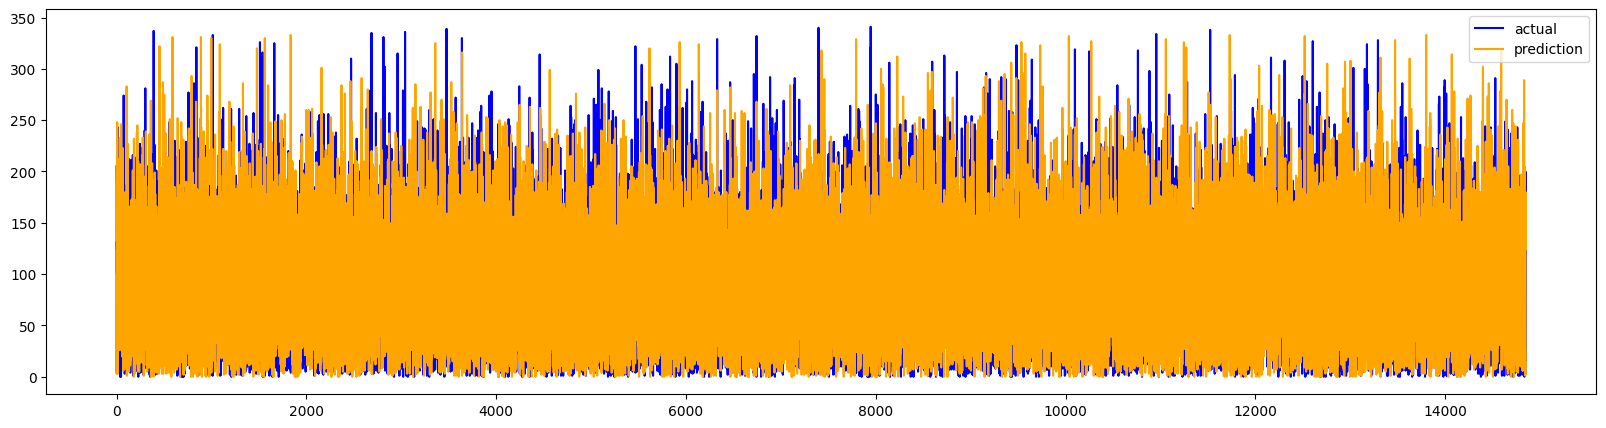

In [37]:
train_pred = best_tft.predict(train_dataloader)
train_actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
train_pred = train_pred[:len(train_actuals)] 
train_pred = torch.tensor(train_pred, dtype=torch.int32)
print("***********Train*********")
evaluate(train_actuals, train_pred)
plot_result(train_actuals, train_pred)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:475: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.
C:\Users\PriyamJha\AppData\Local\Temp\ipykernel_12756\303568130.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_pred = torch.tensor(train_pred, dtype=torch.int32)


RMSE: 85.88
MAE: 68.46
r2 score: -0.98
MAPE: 249.95


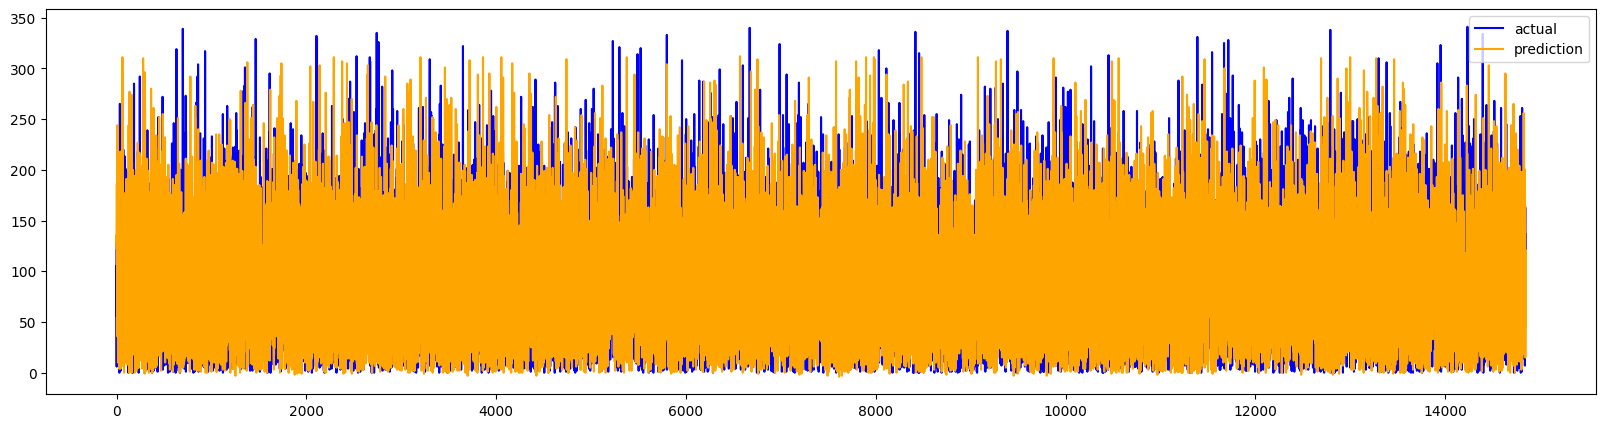

In [26]:
train_pred = best_tft.predict(train_dataloader)
train_actuals = torch.cat([y[0] for x, y in iter(train_dataloader)])
train_pred = train_pred[:len(train_actuals)] 
train_pred = torch.tensor(train_pred, dtype=torch.int32)
evaluate(train_actuals, train_pred)
plot_result(train_actuals, train_pred)

test

c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\pytorch_forecasting\data\encoders.py:314: UserWarning: Found 100 unknown classes which were set to NaN
  warnings.warn(
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000288D9C3A840>
Traceback (most recent call last):
  File "c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\torch\utils\data\dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\torch\utils\data\dataloader.py", line 1435, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\lightning\pytor

In [68]:
test_pred =  tft.predict(test_dataloader)
# test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
# # Evaluate test set

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


In [137]:
test_actual = pd.read_csv("../data/test_data_rul.csv")['RUL'].values 

In [138]:
len(test_actual), len(test_pred)

(13096, 11096)

RMSE: 88.74
MAE: 72.45
r2 score: -1.34
MAPE: 70.19


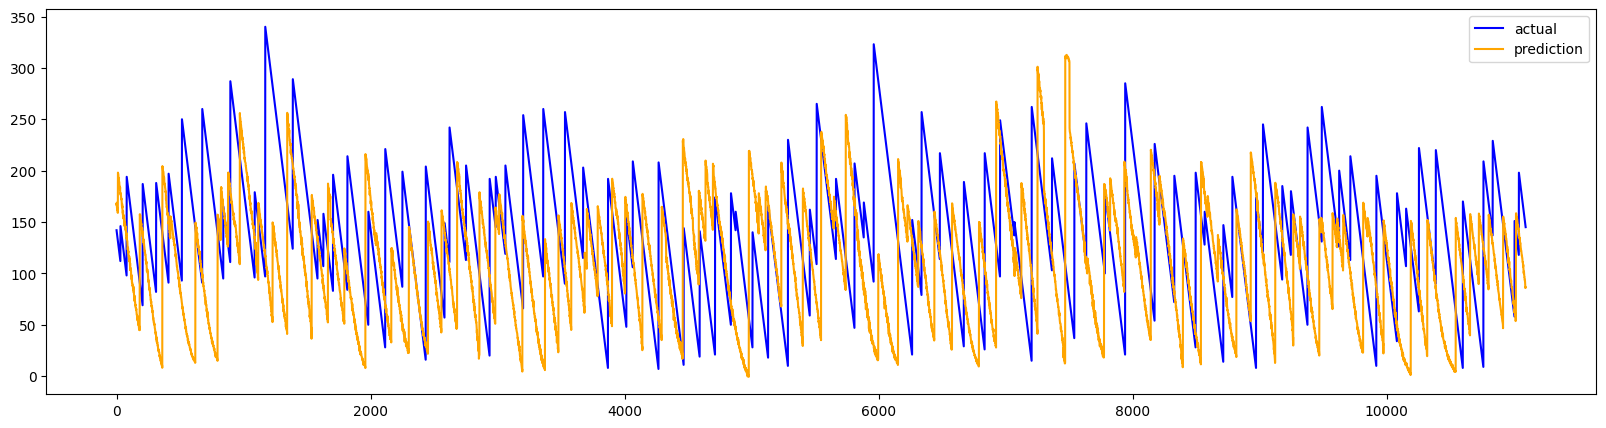

In [116]:
evaluate(test_actual[:11096], test_pred.squeeze())
plot_result(test_actual[:11096], test_pred.squeeze())

RMSE: 64.31
MAE: 50.12
r2 score: -0.33
MAPE: 40.90


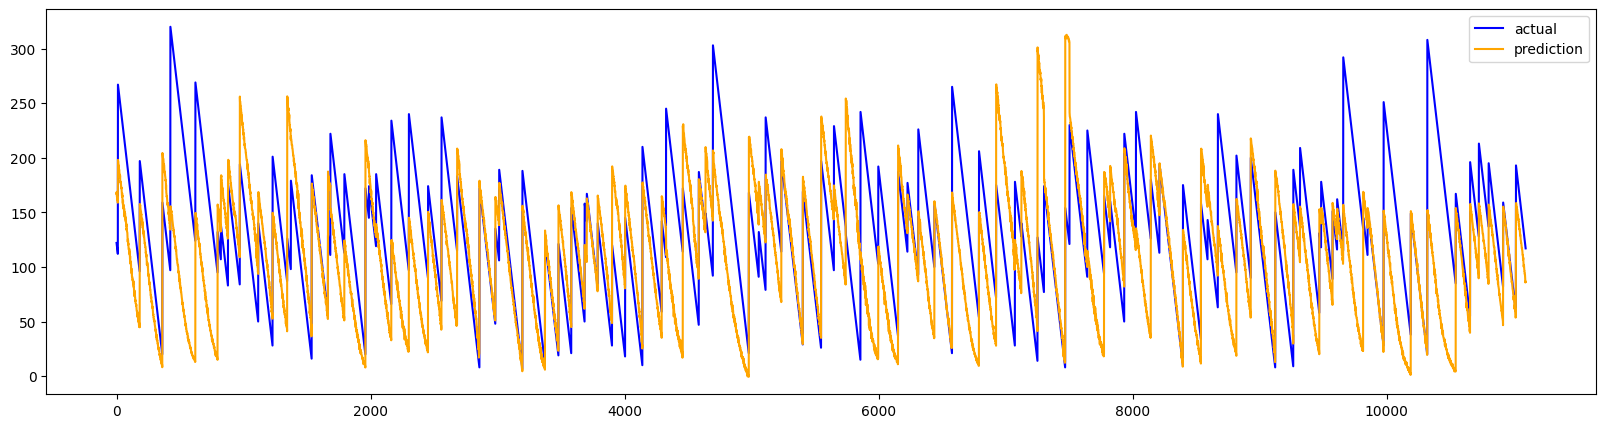

In [108]:
evaluate(test_actuals, test_pred)
plot_result(test_actuals, test_pred)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


RMSE: 64.31
MAE: 50.12
r2 score: -0.33
MAPE: 40.90


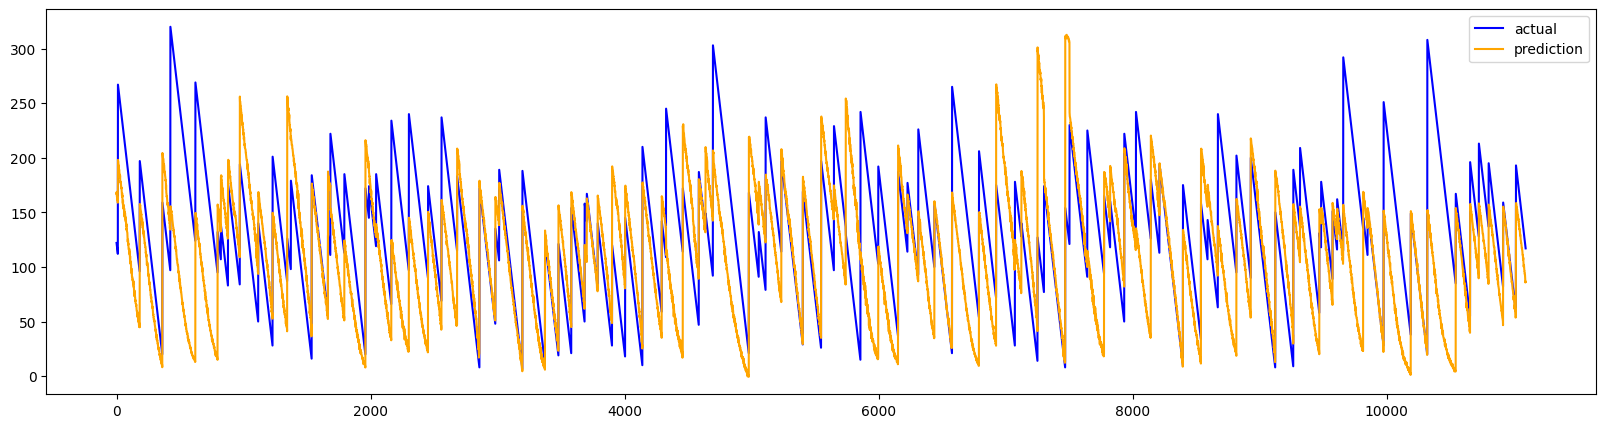

In [ ]:
test_pred =  best_tft.predict(test_dataloader)
test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
# Evaluate test set
evaluate(test_actuals, test_pred)
plot_result(test_actuals, test_pred)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


RMSE: 64.31
MAE: 50.12
r2 score: -0.33
MAPE: 40.90


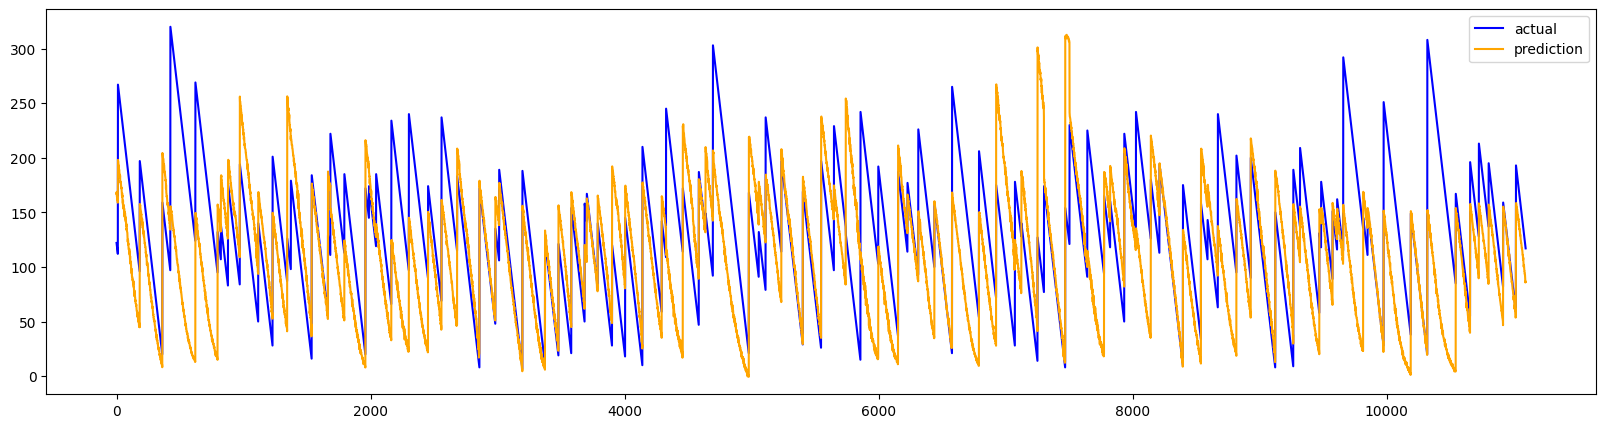

In [ ]:
test_pred =  best_tft.predict(test_dataloader)
test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
# Evaluate test set
evaluate(test_actuals, test_pred)
plot_result(test_actuals, test_pred)

without callback

R² (R-squared): Measures how well the model explains the variance in the data. A higher R² (closer to 1) means the model fits the data better.

RMSE: 27.10
MAE: 13.70
r2 score: 0.76
MAPE: 7.80


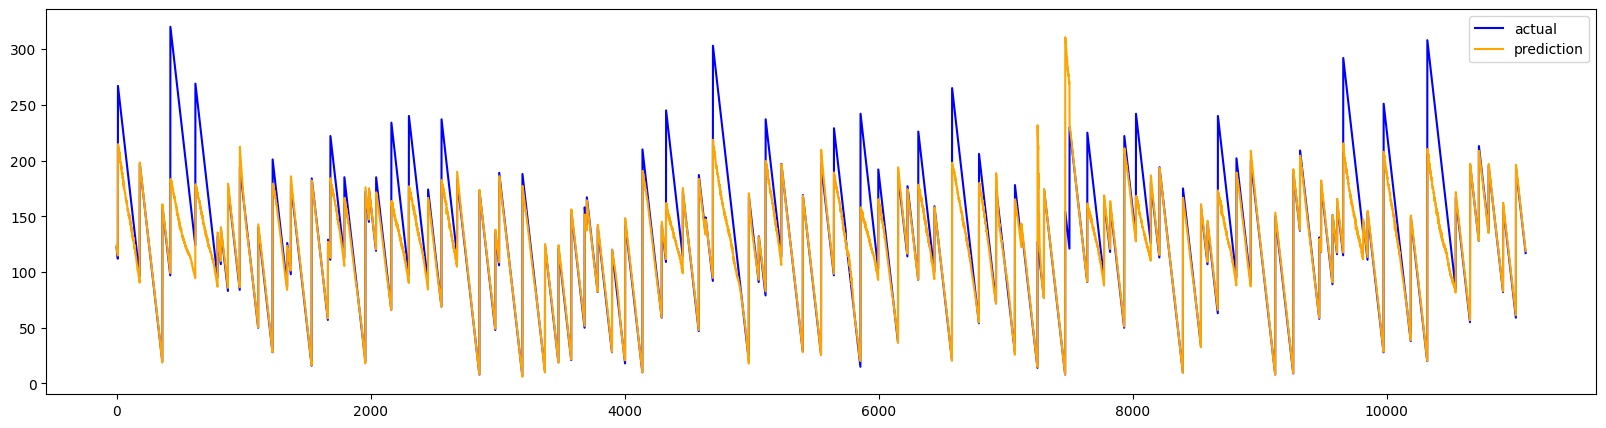

In [ ]:
test_pred =  best_tft.predict(test_dataloader)
test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
# Evaluate test set
evaluate(test_actuals, test_pred)
plot_result(test_actuals, test_pred)

validation

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\PriyamJha\Documents\Github\predictive_maintenance_iitj\pm_env\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


RMSE: 58.24
MAE: 45.07
r2 score: 0.38
MAPE: 60.95


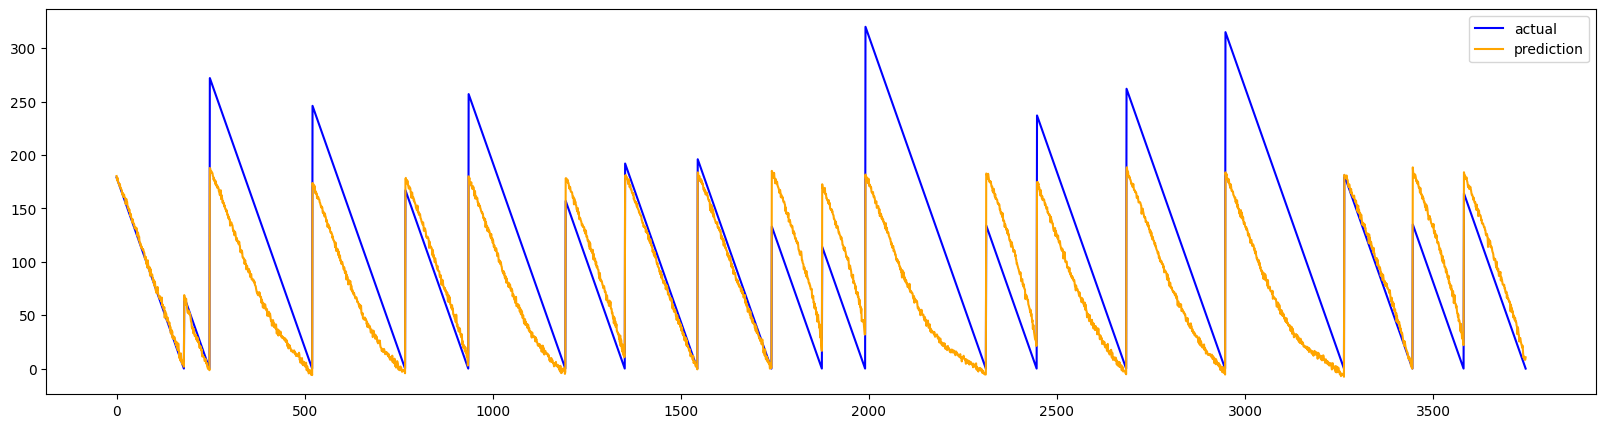

In [ ]:
val_pred =  best_tft.predict(val_dataloader)
val_actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
# Evaluate val set
evaluate(val_actuals, val_pred)
plot_result(val_actuals, val_pred)